In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import random
from imblearn.over_sampling import SMOTENC

In [2]:
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)
full_data = pd.read_csv('cleaned_data/diabetes_cleaned.csv', index_col = 0)

In [3]:
from sklearn.metrics import roc_curve, auc

def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

#### SMOTENC: Used to balance the distribution of responses in readmitted

In [4]:
X_train = train.drop(columns="readmitted")
y_train = train.loc[:, "readmitted"]

X_train_types = X_train.dtypes.to_frame().rename(columns={0: "type"})
# get the name of all variables that are objects
object_vars = list(X_train_types.loc[X_train_types.type == "object", :].index)
object_vars = object_vars + ["age", "admission_type_id", "discharge_disposition_id", "admission_source_id", "time_in_hospital", "num_of_changes"]

# get the indices of all 
object_var_indices = []
for i in range(0, len(X_train.columns)):
    if X_train.columns[i] in object_vars:
        object_var_indices.append(i)

In [5]:
smote_nc = SMOTENC(categorical_features=object_var_indices, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [6]:
# add the readmitted data back in
X_resampled.loc[:, "readmitted"] = y_resampled
train1 = X_resampled.copy()

In [10]:
dummy_preds = ["age", "time_in_hospital", "admission_type_id", "discharge_disposition_id", "admission_source_id", 
               "diag_1", "diag_2", 'diabetesMed','change']
train1_dummy = train1.copy()
test_dummy = test.copy()
vars = []

for pred in dummy_preds:
    dummy_train = pd.get_dummies(train1.loc[:, pred])
    dummy_train.columns = [pred + str(x) for x in dummy_train.columns]
    train1_dummy = pd.concat([train1_dummy, dummy_train], axis=1)
    vars.append(list(dummy_train.columns))
    
    dummy_test = pd.get_dummies(test.loc[:, pred])
    dummy_test.columns = [pred + str(x) for x in dummy_test.columns]
    test_dummy = pd.concat([test_dummy, dummy_test], axis=1)

### Single best model from Amy's model optimization

In [32]:
modified_form = 'readmitted ~ age + diag_1circulatory + diag_1diabetes + diag_1digestive + diag_1injury + diag_1musculoskeletal + diag_1neoplasms + diag_1other + diag_1pregnecy + time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + discharge_disposition_id7 + discharge_disposition_id18 + admission_type_id1 + admission_type_id3 + num_of_changes + number_inpatient + diag_2circulatory + diag_2diabetes + diag_2digestive + diag_2injury + diag_2musculoskeletal + diag_2other'
modified_form

'readmitted ~ age + diag_1circulatory + diag_1diabetes + diag_1digestive + diag_1injury + diag_1musculoskeletal + diag_1neoplasms + diag_1other + diag_1pregnecy + time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + discharge_disposition_id7 + discharge_disposition_id18 + admission_type_id1 + admission_type_id3 + num_of_changes + number_inpatient + diag_2circulatory + diag_2diabetes + diag_2digestive + diag_2injury + diag_2musculoskeletal + diag_2other'

In [33]:
single_model = sm.logit(formula = modified_form,
 data = train1_dummy).fit() 
single_model.summary()

Optimization terminated successfully.
         Current function value: 0.631324
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104429
Method:                           MLE   Df Model:                           34
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                 0.08919
Time:                        20:38:12   Log-Likelihood:                -65951.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.1085      0.092    -33.627      0.000      -3.290      -2.927
age                            0.0184      0.000     38.047      0.000       0.017       0.019
diag_1circulatory              0.8720      0.020     43.190      0.000       0.832       0.912
diag_1diabetes                 0.3139      0.031     10.206      0.000       0.254       0.374
diag_1digestive                0.0804      0.029      2.737      0.006       0.023       0.138
diag_1injury                   0.4394      0.031     14.228      0.000       0.379       0.500
diag_1musculoskeletal          0.3534      0.036      9.724      0.000       0.282       0.425
diag_1neoplasms                0.2721      0.043      6.324      0.000       0.188       0.356
diag_1other                    0.5343      0.023     22.970      0.000       0.489       0.580
diag_1pregnecy                -0.2916      0.141     -2.074      0.038      -0.567      -0.016
time_in_hospital1              0.3126      0.081      3.861      0.000       0.154       0.471
time_in_hospital2              0.5690      0.080      7.073      0.000       0.411       0.727
time_in_hospital3              0.6815      0.080      8.485      0.000       0.524       0.839
time_in_hospital4              0.7355      0.081      9.112      0.000       0.577       0.894
time_in_hospital5              0.6525      0.082      8.004      0.000       0.493       0.812
time_in_hospital6              0.8142      0.082      9.910      0.000       0.653       0.975
time_in_hospital7              0.7034      0.083      8.439      0.000       0.540       0.867
time_in_hospital8              0.8266      0.085      9.728      0.000       0.660       0.993
time_in_hospital9              0.4588      0.089      5.163      0.000       0.285       0.633
time_in_hospital10             0.6853      0.091      7.539      0.000       0.507       0.863
time_in_hospital11             0.3065      0.096      3.198      0.001       0.119       0.494
time_in_hospital12             0.5064      0.099      5.110      0.000       0.312       0.701
time_in_hospital13             0.2315      0.106      2.186      0.029       0.024       0.439
discharge_disposition_id7     -1.7894      0.179     -9.994      0.000      -2.140      -1.439
discharge_disposition_id18     0.2548      0.031      8.285      0.000       0.195       0.315
admission_type_id1             0.4799      0.022     21.354      0.000       0.436       0.524
admission_type_id3            -0.4548      0.028    -16.076      0.000      -0.510      -0.399
num_of_changes                -0.4981      0.016    -31.039      0.000      -0.530      -0.467
number_inpatient               0.1586      0.011     14.835      0.000       0.138       0.180
diag_2circulatory              0.6848      0.020     34.342      0.000       0.646       0.724
diag_2diabetes                 0.4601      0.025     18.273      0.000       0.411       0.509
diag_2diges

Classification accuracy = 64.2%
Precision = 63.4%
TPR or Recall = 67.3%
FNR = 32.7%
FPR = 38.8%
ROC-AUC = 69.5%


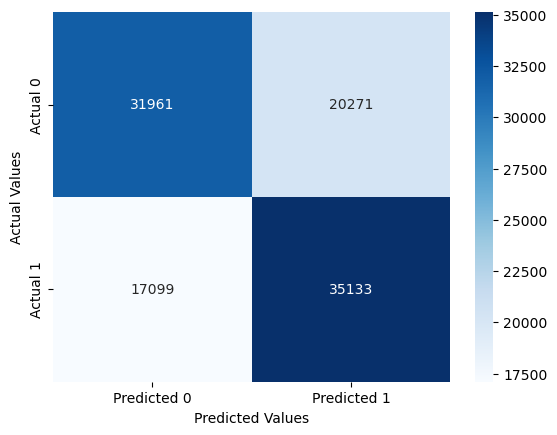

In [34]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, single_model, cutoff=0.5)

Classification accuracy = 59.6%
Precision = 10.3%
TPR or Recall = 44.2%
FNR = 55.8%
FPR = 38.9%
ROC-AUC = 54.0%


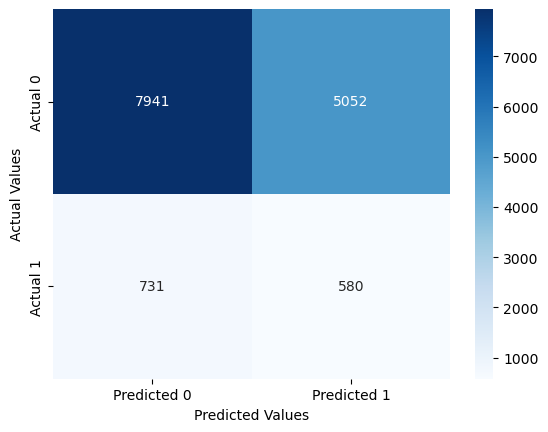

In [35]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, single_model, cutoff=0.5)

### Attempting feature selection using SkLearn

In [8]:
from sklearn.linear_model import LogisticRegression

In [11]:
# getting a list of the all the usable numerical predictors
preds = train1_dummy.dtypes[train1_dummy.dtypes != object].index.tolist()
# dropping the unusable and duplicate numeric predictors
preds.remove('age')
preds.remove('time_in_hospital')
preds.remove('admission_type_id')
preds.remove('discharge_disposition_id')
preds.remove('admission_source_id')
preds.remove('encounter_id')
preds.remove('patient_nbr')
preds.remove('discharge_disposition_id27')
preds.remove('readmitted')

In [12]:
# creating the features and the response for skLearn
sk_X = train1_dummy[preds]
sk_y = train1_dummy.readmitted

In [13]:
# creating the penalized model and fit
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(sk_X,sk_y)

LogisticRegression(penalty='l1', solver='liblinear')

In [15]:
# getting a list of significant predictors 
# whose coefficient is not zero
coefs = log.coef_
sig_preds = np.array(preds)[np.where(coefs != 0)[1]]

In [16]:
sig_preds

array(['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'num_of_changes', 'age5', 'age15', 'age25',
       'age35', 'age45', 'age55', 'age65', 'age75', 'age85', 'age95',
       'time_in_hospital1', 'time_in_hospital2', 'time_in_hospital3',
       'time_in_hospital4', 'time_in_hospital5', 'time_in_hospital6',
       'time_in_hospital7', 'time_in_hospital8', 'time_in_hospital9',
       'time_in_hospital10', 'time_in_hospital11', 'time_in_hospital12',
       'time_in_hospital13', 'time_in_hospital14', 'admission_type_id1',
       'admission_type_id3', 'admission_type_id4', 'admission_type_id5',
       'discharge_disposition_id1', 'discharge_disposition_id2',
       'discharge_disposition_id7', 'discharge_disposition_id10',
       'discharge_disposition_id11', 'discharge_disposition_id18',
       'admission_source_id1', 'admission_source_id4',
       'admission_source_id7', 'admission_s

Classification accuracy = 69.9%
Precision = 68.7%
TPR or Recall = 73.0%
FNR = 27.0%
FPR = 33.3%
ROC-AUC = 69.9%


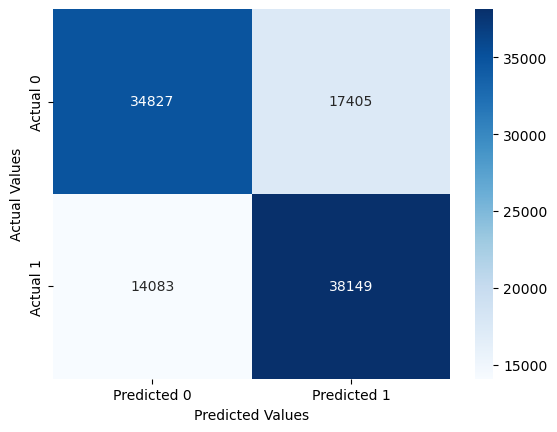

In [41]:
confusion_matrix_data(train1_dummy[preds], train1_dummy.readmitted,log,cutoff=0.5)


Classification accuracy = 64.5%
Precision = 11.3%
TPR or Recall = 41.6%
FNR = 58.4%
FPR = 33.1%
ROC-AUC = 54.3%


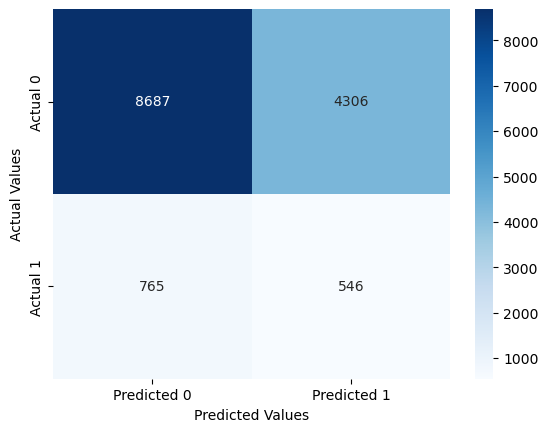

In [42]:
confusion_matrix_data(test_dummy[preds], test_dummy.readmitted,log,cutoff=0.5)

### Attempting Interaction Variables

### Variable interactions to test out:
- change * diabetesMed
- age * time_in_hospital
- age * number_inpatient
- change * admission_source_id

Without using the significant predictors from the previous model

In [43]:
model = sm.logit(formula = "readmitted~age*time_in_hospital+age*number_inpatient+num_lab_procedures+num_procedures+num_medications+number_outpatient+number_emergency+number_diagnoses+num_of_changes+ diabetesMed+diag_1+diag_2+change*admission_source_id", data = train1).fit_regularized()
model.summary()


/Users/ac/opt/anaconda3/envs/stat/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ac/opt/anaconda3/envs/stat/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6038279660903911
            Iterations: 187
            Function evaluations: 201
            Gradient evaluations: 187


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104429
Method:                           MLE   Df Model:                           34
Date:                Sat, 11 Mar 2023   Pseudo R-squ.:                  0.1289
Time:                        14:30:18   Log-Likelihood:                -63078.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -2.6365      0.074    -35.803      0.000      -2.781      -2.492
diabetesMed[T.Yes]                   1.4098      0.021     66.071      0.000       1.368       1.452
diag_1[T.diabetes]                  -0.6342      0.029    -21.877      0.000      -0.691      -0.577
diag_1[T.digestive]                 -0.7095      0.028    -25.773      0.000      -0.763      -0.656
diag_1[T.genitourinary]             -0.8655      0.036    -23.754      0.000      -0.937      -0.794
diag_1[T.injury]                    -0.4415      0.029    -15.220      0.000      -0.498      -0.385
diag_1[T.musculoskeletal]           -0.7549      0.034    -22.039      0.000      -0.822      -0.688
diag_1[T.neoplasms]                 -0.6282      0.043    -14.616      0.000      -0.712      -0.544
diag_1[T.other]                     -0.4040      0.020    -19.866      0.000      -0.444      -0.364
diag_1[T.pregnecy]                  -0.7916      0.172     -4.602      0.000      -1.129      -0.454
diag_1[T.respiratory]               -0.9866      0.023    -42.155      0.000      -1.032      -0.941
diag_2[T.diabetes]                  -0.3076      0.023    -13.497      0.000      -0.352      -0.263
diag_2[T.digestive]                 -0.7121      0.044    -16.275      0.000      -0.798      -0.626
diag_2[T.genitourinary]             -0.6994      0.030    -23.293      0.000      -0.758      -0.641
diag_2[T.injury]                    -0.8588      0.053    -16.095      0.000      -0.963      -0.754
diag_2[T.musculoskeletal]           -1.1842      0.073    -16.222      0.000      -1.327      -1.041
diag_2[T.neoplasms]                 -0.6146      0.053    -11.538      0.000      -0.719      -0.510
diag_2[T.other]                     -0.0445      0.018     -2.516      0.012      -0.079      -0.010
diag_2[T.pregnecy]                  -1.0631      0.257     -4.133      0.000      -1.567      -0.559
diag_2[T.respiratory]               -0.7161      0.026    -27.173      0.000      -0.768      -0.664
change[T.No]                         0.0215      0.030      0.709      0.478      -0.038       0.081
age                                  0.0281      0.001     31.435      0.000       0.026       0.030
time_in_hospital                     0.1645      0.012     13.308      0.000       0.140       0.189
age:time_in_hospital                -0.0023      0.000    -13.246      0.000      -0.003      -0.002
number_inpatient                     0.2730      0.050      5.441      0.000       0.175       0.371
age:number_inpatient                -0.0020      0.001     -2.747      0.006      -0.003      -0.001
num_lab_procedures                   0.0030      0.000      7.457      0.000       0.002       0.004
num_procedures                      -0.2047      0.005    -41.616      0.000      -0.214      -0.195
num_medications                      0.0229      0.001     20.961      0.000       0.021       0.025
number_ou

Classification accuracy = 67.6%
Precision = 66.6%
TPR or Recall = 70.6%
FNR = 29.4%
FPR = 35.4%
ROC-AUC = 73.6%


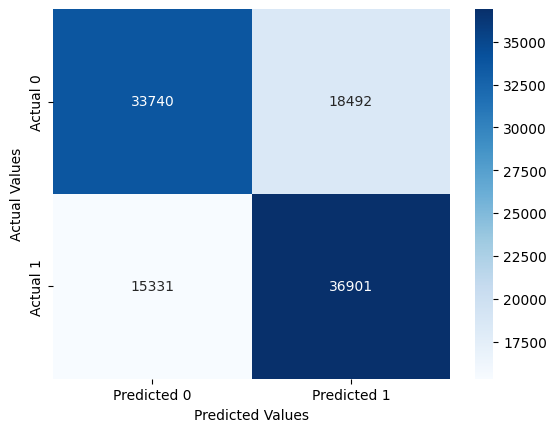

In [44]:
confusion_matrix_data(train1, train1.readmitted, model, cutoff=0.5)


Classification accuracy = 62.5%
Precision = 10.7%
TPR or Recall = 42.3%
FNR = 57.7%
FPR = 35.4%
ROC-AUC = 54.9%


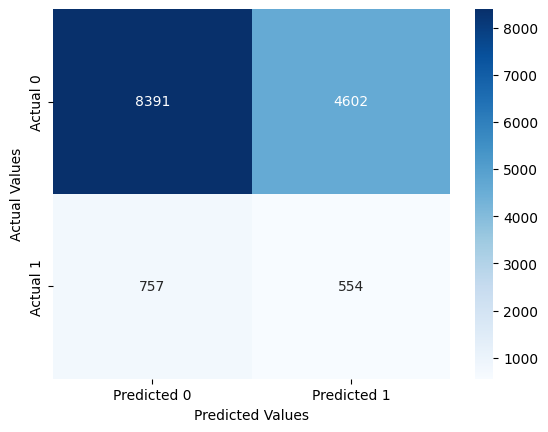

In [45]:
confusion_matrix_data(test, test.readmitted, model, cutoff=0.5)

### Reattempt using SkLearn w/ significant predictors

In [17]:
from patsy import dmatrices

In [25]:
# creating the formula
f = 'num_lab_procedures'
for i in sig_preds[1:]:
    f = f + '+' + i

In [26]:
# adding interations on to the formula
f1 = f+'+change*diabetesMed+(age5+age15+age25+age35+age45+age55+age65+age75+age85+age95)*(time_in_hospital1+time_in_hospital2+time_in_hospital3+time_in_hospital4+time_in_hospital5+time_in_hospital6+time_in_hospital7+time_in_hospital8+time_in_hospital9+time_in_hospital10+time_in_hospital11+time_in_hospital12+time_in_hospital13+time_in_hospital14)+(age5+age15+age25+age35+age45+age55+age65+age75+age85+age95)*number_inpatient+change*(admission_type_id1+admission_type_id3+admission_type_id4+admission_type_id5)'

In [37]:
f1

'num_lab_procedures+num_procedures+num_medications+number_outpatient+number_emergency+number_inpatient+number_diagnoses+num_of_changes+age5+age15+age25+age35+age45+age55+age65+age75+age85+age95+time_in_hospital1+time_in_hospital2+time_in_hospital3+time_in_hospital4+time_in_hospital5+time_in_hospital6+time_in_hospital7+time_in_hospital8+time_in_hospital9+time_in_hospital10+time_in_hospital11+time_in_hospital12+time_in_hospital13+time_in_hospital14+admission_type_id1+admission_type_id3+admission_type_id4+admission_type_id5+discharge_disposition_id1+discharge_disposition_id2+discharge_disposition_id7+discharge_disposition_id10+discharge_disposition_id11+discharge_disposition_id18+admission_source_id1+admission_source_id4+admission_source_id7+admission_source_id8+admission_source_id9+admission_source_id11+diag_1circulatory+diag_1diabetes+diag_1digestive+diag_1genitourinary+diag_1injury+diag_1musculoskeletal+diag_1neoplasms+diag_1other+diag_1pregnecy+diag_1respiratory+diag_2circulatory+diag

In [27]:
# creating features for sklearn w/ interactions using patsy
# test data
y0,X0 = dmatrices("readmitted~"+f1, train1_dummy)

In [28]:
# same thing here for train data
y1,X1 =  dmatrices("readmitted~"+f1, test_dummy) 

In [29]:
# fit the logistic model
log.fit(X0,y0)

/Users/ac/opt/anaconda3/envs/stat/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty='l1', solver='liblinear')

In [30]:
# get the name of the predictors
coef_names = X0.design_info.column_names

In [31]:
# get the list of coeffceints
coefs0 = log.coef_

In [32]:
# find the list of the predictors
# whose coefficient is non zero
sig_preds0 = np.array(coef_names)[np.where(coefs0 != 0)[1]]

In [33]:
# Here's the list of the coefficient
sig_preds0

array(['Intercept', 'change[T.No]', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'num_of_changes', 'age5', 'age15', 'age25', 'age35', 'age45',
       'age55', 'age65', 'age75', 'age85', 'age95', 'time_in_hospital1',
       'time_in_hospital2', 'time_in_hospital3', 'time_in_hospital4',
       'time_in_hospital6', 'time_in_hospital7', 'time_in_hospital8',
       'time_in_hospital9', 'time_in_hospital10', 'time_in_hospital11',
       'time_in_hospital13', 'time_in_hospital14', 'admission_type_id1',
       'change[T.No]:admission_type_id1', 'admission_type_id3',
       'change[T.No]:admission_type_id3', 'admission_type_id5',
       'discharge_disposition_id1', 'discharge_disposition_id2',
       'discharge_disposition_id7', 'discharge_disposition_id10',
       'discharge_disposition_id11', 'discharge_disposition_id18',
       'admission_source_id1', 'admission_source_id4',
  

In [34]:
# list of the coefficients
np.array(coefs0)[np.where(coefs0 != 0)]

array([-2.74995917e-01, -1.07395398e-02,  6.44747471e-04, -1.84816642e-01,
        2.69272218e-02, -1.07861423e-01, -1.23252334e-01,  1.56952281e-01,
       -6.06088463e-02, -7.57727012e-01, -3.45643704e+00, -1.10886486e+00,
       -9.22686644e-01, -2.83527527e-01, -1.36777751e-01,  3.85351647e-05,
        3.66922432e-01,  5.69240566e-01,  3.47206376e-01, -5.91626684e-01,
       -1.58991758e-01, -1.40498532e-02, -9.47565101e-03,  4.71345942e-02,
        1.64973921e-01,  7.89796562e-02,  3.39098356e-01, -1.08091718e-01,
        1.76903392e-02, -3.07628499e-01, -3.78519356e-01, -7.93481019e-01,
        2.88884432e-01,  5.76063702e-02, -5.13555317e-01, -4.03787673e-02,
       -2.13585786e-01, -4.43311037e-02,  1.57175364e-01, -1.76927009e+00,
       -3.11776024e-01, -6.68716407e+00,  3.61368649e-01, -8.16828179e-02,
       -8.17486157e-01,  4.53589565e-02, -1.35795293e+00,  8.13452250e-03,
       -8.89053524e-02,  5.40906870e-01, -5.61181090e-02, -1.81194815e-01,
       -2.96055243e-01,  

Classification accuracy = 69.9%
Precision = 68.7%
TPR or Recall = 73.2%
FNR = 26.8%
FPR = 33.4%
ROC-AUC = 69.9%


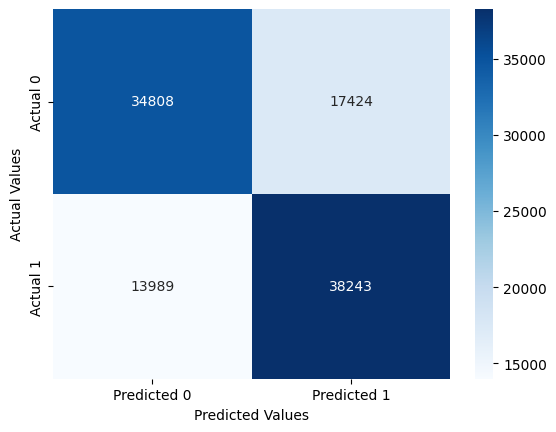

In [38]:
# Test Data Metrics
confusion_matrix_data(np.asarray(X0), train1_dummy.readmitted, log, cutoff=0.5)

Classification accuracy = 64.6%
Precision = 11.3%
TPR or Recall = 41.8%
FNR = 58.2%
FPR = 33.1%
ROC-AUC = 54.4%


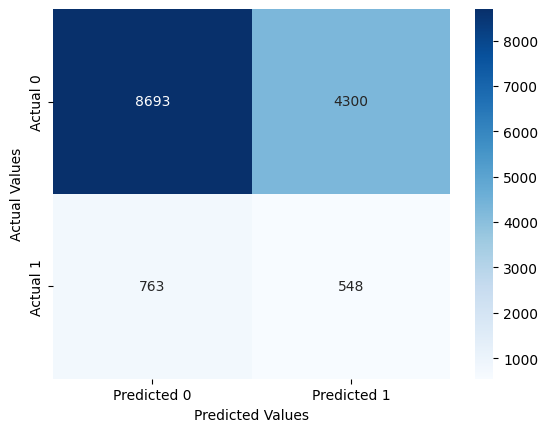

In [39]:
# Test Data Accuracy
confusion_matrix_data(np.asarray(X1), test_dummy.readmitted, log, cutoff=0.5)